
 <H1><center>Renato’s Game<br><br> (Variation)</center></H1>
By <b>Rafal Pracht</b> $\land$ <b>Cristeam Caiola</b>



<img src="renatoV3.jpg" >Image 1


# Summary
N players, who can communicate only two classical bits on a chain:  $\alpha_1$ -> $\alpha_2$ -> $\alpha_3$ … -> $\alpha_N$ <br>
Each player $\alpha_i$ receives as input a real number $\alpha_i$.<br>
Promise: $\sum  \alpha_i = K \in  \mathbb{N}$.<br>
Last player $\alpha_N$ should tell the referee whether K is even or odd.<br>
Players are allowed to share a strategy (in particular, to share a large entangled state) before the game starts i.e. before they know the alphas ($\alpha$).

# Solution
We implemented 2 solution: One by making use of Rx gate (our solution) and another one by using U1 gate (Renato's solution).

In our solution (with 2 gates less than Renato's one) the Rx gates map the real number from each player by multiplying by π and then we prepare the rotation by x axes on the Bloch sphere by this angle after all this rotations regarding to our promise we are landing in the angle 2K * π for even number (state 0) and K * π for odd number (state 1)

In Renato's solution  the state is encode in his formulas ( showed in the image 1) 

The solution has a short version more readable for 3 players using 5 qbits and an extended one with 10 players using 19 qbits, Both solution has a flag called "is_variation" to define if we want to use Renato's solution or ours.



# Evaluation criteria:
- Does it run? -> 100% for both 2 version  <br>
- Is it interesting?-> Of course it is a game! using teleportation<br> 
- Is it new -> Totally brand new (Qiskit implementation) 
- Translation from other languages? -> No translation
- contribution:?*<br>
 *We found a <b>bug</b> when using the Qiskit library to draw the circuits. This error has flaged in the Qiskit Git hub repository and we are working in the solution. 
In details  when using qiskit version 0.9 we cannot draw the circuit by using circuit.draw(output='mpl') but instead circuit.draw(output='text'). In version 0.8 both commands works well.

# Gates used:


$
U_1(\lambda)=
\begin{bmatrix}
    1       & 0   \\
    0       & e^{ i \lambda}   \\
\end{bmatrix}
$

$
Rx(\theta)=
\begin{bmatrix}
    \cos (\theta/2)       & -i\sin (\theta/2)   \\
    -i \sin(\theta/2)       & cos (\theta/2)   \\
\end{bmatrix}
$


In [2]:
#Import libraries from qiskit  
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, IBMQ, Aer
from qiskit import execute
import numpy as np


In [3]:
#Choose local backends qasm_simulator
backend = Aer.get_backend('qasm_simulator')

# Methods 



In [4]:
def bell(qc, idx1, idx2):
    """The method create the bell state between two qbits. 
        qc - The Quantum circuit
        idx1 - the index of the first register
        idx2 - the index of the secound register"""
    qc.h(idx1)
    qc.cx(idx1, idx2)

In [5]:
def encode_number(qc, n, idx, is_variation):
    """The method encode the quantum operation to add the real nuber to current sum.
        qc - The Quantum circuit
        n - the number to add
        idx - the index of the first register
        is_variation - true if we use Rx gate and false for the orginal solution, U1 gate"""
    if (is_variation):
        qc.rx(np.pi * n, idx)
    else:
        qc.u1(np.pi * n, idx)

In [6]:
def do_teleportation(qc, q, idx_q, idx_player1_bell_q, idx_player2_bell_q, cl_reg1, cl_reg2):
    """The method move the quantum state using the quantum teleportation.
        qc - The Quantum circuit
        q - The quantum registers
        idx_q - the index of qbit to teleport
        idx_player1_bell_q - the index of the bell qubit which belong to first player
        idx_player2_bell_q - the index of the bell qubit which belong to first player
        cl_reg1 - the first classical register used to transfer 1 bit
        cl_reg2 - the secound classical register used to transfer 1 bit"""
    # Barrier following state preparation
    qc.barrier()

    # Measure in the Bell basis
    qc.cx(idx_q, idx_player1_bell_q)
    qc.h(idx_q)
    qc.measure(q[idx_q], cl_reg1)
    qc.measure(q[idx_player1_bell_q], cl_reg2)

    # Apply a correction
    qc.barrier()
    qc.z(idx_player2_bell_q).c_if(cl_reg1, 1)
    qc.x(idx_player2_bell_q).c_if(cl_reg2, 1)

In [7]:
def extract_result(results):
    """This method print the result of the game
         results - list of result from the game execution to be interated
    """    
    res = [False, False]
    for v in results.get_counts():
        res[int(v[0])] = True
    if res[0] and res[1]:
        raise "Invalid output"
    if (res[0]):
        print("The number is even")
    else:
        print("The number is odd")

In [8]:
def prepare_circuit(numbers, sumK, is_variation):
    """Method prepare the circuit to Renat's game
        numbers - the array of numbers
        sumK - the pramise natural number, the number for the last player will be sumK - numbers
        is_variation - true if we use Rx gate and false for the orginal solution, U1 gate"""
    number_of_player = len(numbers) + 1
    number_of_qbit = 2 * number_of_player - 1
    print("The game with " + str(number_of_player) + " players, qubits: " + str(number_of_qbit))
    
    # calculate the last number
    numbers.append(sumK - sum(numbers))
    
    # create a quantum circuit
    q = QuantumRegister(number_of_qbit)
    cReg = []
    for i in range(number_of_qbit):
        cReg.append(ClassicalRegister(1, "c" + str(i)))
    qc = QuantumCircuit(q, *cReg)
    
    # Prepare the Bell state
    for player in range(number_of_player - 1):
        bell(qc, 2 * player + 1, 2 * player + 2)
    qc.barrier()
    
    # In case of the orginal game, we should put h gate before we start encode the numbers
    if (not is_variation):
        qc.h(0)
    
    for player in range(number_of_player - 1):
        encode_number(qc, numbers[player], player * 2, is_variation)
        do_teleportation(qc, q, player * 2, player * 2 + 1, (player + 1) * 2, cReg[player * 2], cReg[player * 2 + 1])   
   
    # the last player
    encode_number(qc, numbers[number_of_player - 1], (number_of_player - 1) * 2, is_variation)
        
    # In case of the orginal game, we should put h gate before measurment but after encode the whole sum
    if (not is_variation):
        qc.h((number_of_player - 1) * 2)
        
    # measure qubit
    qc.measure(q[(number_of_player - 1) * 2], cReg[(number_of_player - 1) * 2])
    
    return qc

In [9]:
def execute_and_print(qc):
    # compile and run the quantum circuit
    shots = 100
    job = execute(qc, backend, shots=shots)
    results = job.result()
    #print("counts:", results.get_counts())
    extract_result(results)
    return results

In [10]:
 #####  #######    #    ######  #######             ####### #     # #######          #####     #    #     # ####### 
#     #    #      # #   #     #    #                   #    #     # #               #     #   # #   ##   ## #       
#          #     #   #  #     #    #                   #    #     # #               #        #   #  # # # # #       
 #####     #    #     # ######     #                   #    ####### #####           #  #### #     # #  #  # #####   
      #    #    ####### #   #      #                   #    #     # #               #     # ####### #     # #       
#     #    #    #     # #    #     #                   #    #     # #               #     # #     # #     # #       
 #####     #    #     # #     #    #                   #    #     # #######         ##### # #     # #     # ####### 
    

<b> Note: </b> To ensure the promise of the game that the sum is a Natural number our input  paramether is not the array of the whole numbers but instead it is the array of numbers N-1 and in the second paramether we will pass the expected sum (which is a natural number ) and finally we calculate the last number by the formula $K - \sum^{n-1} \alpha_i = \alpha_n$<br>

The game with 10 players, qubits: 19
The number is odd


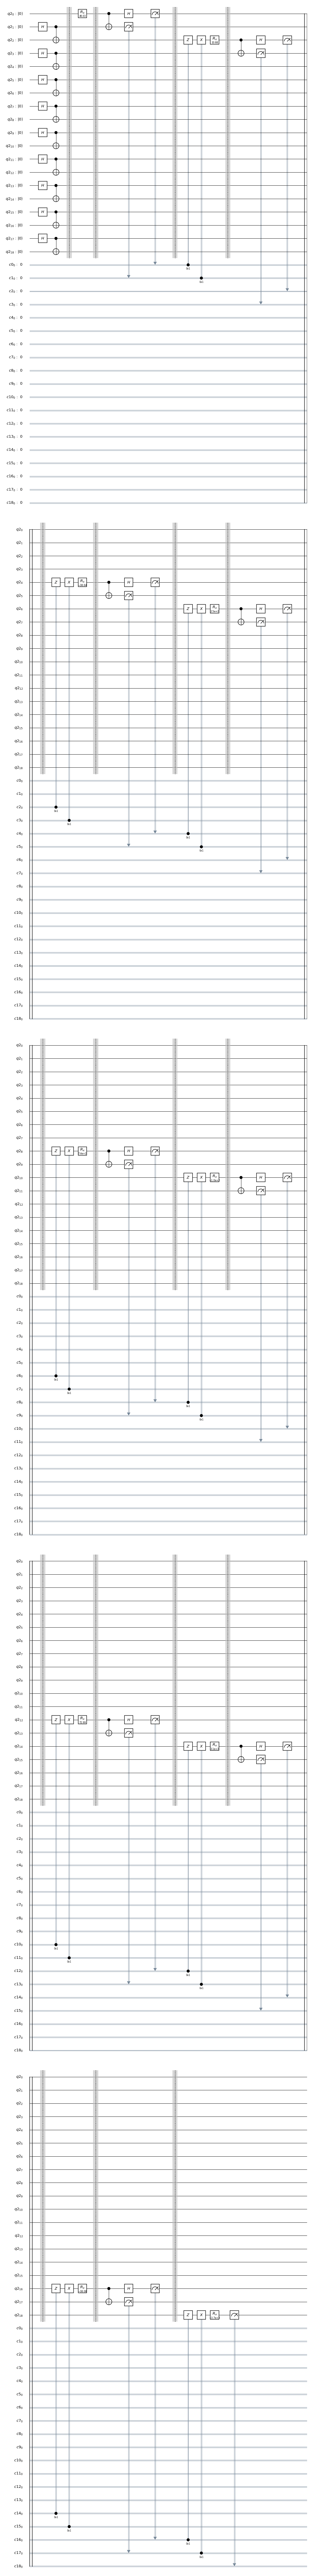

In [13]:

#Options
qc = prepare_circuit([14.6523, 3.4, -12.3, 78.97365, 234.123, -32.1313, 23.2323, 988.1231, -12.1213], 123, True)
#qc = prepare_circuit([14.6523, -12.3], 47, True)
#qc = prepare_circuit([14.6523, -12.3], 48, False)
#qc = prepare_circuit([14.6523, 3.4, -12.3, 78.97365, 234.123, -32.1313, 23.2323, 988.1231], 99, False)

r=execute_and_print(qc)

# plot the circuit
#qc.draw(output='text') #Qiskit lastest version (0.9)
qc.draw(output='mpl') #Qiskit version 0.8

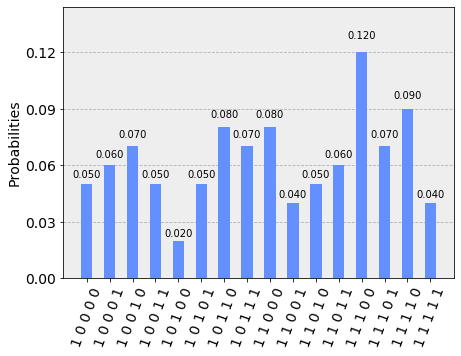

In [101]:
# Plot a histogram
plot_histogram(r.get_counts())